____

# <font color=#FFAA11> Two-Temperature Model </font>

The TTM considered here is given by
$$\begin{align}
c_e \frac{\partial T_e}{\partial t} &= \frac{1}{r}\frac{\partial}{\partial r}\left(r k_e \frac{\partial T_e}{\partial r}\right) - G (T_e - T_i), \\
c_i\frac{\partial T_i}{\partial t} &= \frac{1}{r}\frac{\partial}{\partial r}\left(r k_i \frac{\partial T_i}{\partial r}\right) + G (T_e - T_i),
\end{align}
$$

which assumes a cylindrical plasma composed of electrons and ions with no mass flow. 

Main areas where major improvements are needed:
1. Plasma Formulary version of parameters
2. Allow density variation 
3. Nicer visualizations, including animations, would be nice to have in the long run.

Current Bug- Electron Heat Capacity definitely not right!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from physics import JT_GMS, SMT
from constants import *
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from exp_setup import Cylindrical_Grid, Experiment
from TTM_solver import TwoTemperatureModel

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Create Experimental Information

In [27]:
grid  = Cylindrical_Grid(100e-6, N=500) 
Zstar, A = 54, 131
Te_initial, Ti_initial = 16.6e3, 10300 #[K]
laser_width = 25e-6 # [m]
n0 = 1.25e20 *1e6

# Create Experimental layout and TTM solver
Xenon_jt = Experiment(grid, n0, Zstar, A, Te_initial, Ti_initial,laser_width, gas_name='Xenon', model = "JT")
ttm_jt = TwoTemperatureModel(Xenon_jt, model = "JT")

Xenon_smt = Experiment(grid, n0, Zstar, A, Te_initial, Ti_initial,laser_width, gas_name='Xenon', model = "SMT")
ttm_smt = TwoTemperatureModel(Xenon_smt, model = "SMT")

Current Te profile not exact, needs self-consistency condition.
Current Te profile not exact, needs self-consistency condition.


In [28]:
print(Xenon_jt.params.electron_thermal_conductivity(Xenon_jt.n_e, Xenon_jt.n_i, Xenon_jt.m_i, Xenon_jt.Zbar, Xenon_jt.Te, Xenon_jt.Ti)/JT_GMS.electron_heat_capacity(Xenon_jt.n_e,Xenon_jt.Te))
print(Xenon_smt.params.electron_thermal_conductivity(Xenon_smt.n_e, Xenon_smt.n_i, Xenon_smt.m_i, Xenon_smt.Zbar, Xenon_smt.Te, Xenon_smt.Ti)/SMT.electron_heat_capacity(Xenon_smt.n_e,Xenon_smt.Te))

[0.00344004 0.00343957 0.00343814 0.00343575 0.00343242 0.00342815
 0.00342294 0.0034168  0.00340974 0.00340178 0.00339291 0.00338317
 0.00337255 0.00336108 0.00334878 0.00333566 0.00332174 0.00330704
 0.00329158 0.00327538 0.00325848 0.00324088 0.00322262 0.00320372
 0.00318421 0.00316411 0.00314344 0.00312225 0.00310055 0.00307837
 0.00305573 0.00303268 0.00300924 0.00298542 0.00296127 0.00293681
 0.00291207 0.00288708 0.00286186 0.00283644 0.00281084 0.0027851
 0.00275924 0.00273328 0.00270725 0.00268118 0.00265508 0.00262897
 0.00260289 0.00257685 0.00255086 0.00252496 0.00249916 0.00247347
 0.00244791 0.00242251 0.00239726 0.00237219 0.00234732 0.00232264
 0.00229818 0.00227393 0.00224993 0.00222616 0.00220264 0.00217937
 0.00215636 0.00213362 0.00211114 0.00208894 0.00206701 0.00204535
 0.00202398 0.00200287 0.00198205 0.0019615  0.00194122 0.00192121
 0.00190148 0.001882   0.00186279 0.00184384 0.00182514 0.00180668
 0.00178848 0.0017705  0.00175277 0.00173525 0.00171796 0.00170

In [29]:
print("JT Model")
ttm_jt.make_times()
ttm_jt.print_timescales()

print("\nSMT Model")
ttm_smt.make_times()
ttm_smt.print_timescales()

JT Model

Simulation time: 4.0e+00 ns,  dt = 1.2e+00 ps, steps = 3425
  Diffusion time (r_max): e:2.9e+03 ns, i:2.6e+44 ns 
  Diffusion time (dr): e:1.2e-02 ns, i:1.0e+39 ns 
  Thermalization Times: 8e+02 ps  8e+02 ps

SMT Model

Simulation time: 6.2e+00 ns,  dt = 5.1e-01 ps, steps = 12121
  Diffusion time (r_max): e:1.3e+03 ns, i:2.6e+44 ns 
  Diffusion time (dr): e:5.1e-03 ns, i:1.0e+39 ns 
  Thermalization Times: 1e+03 ps  1e+03 ps


# Solve Two Temperature Model

In [30]:
ttm_jt.solve_TTM(tmax=18e-9)
ttm_smt.solve_TTM(tmax=18e-9)

# PLOTS

In [35]:
def plot_temp_profiles(ttm, grid, plot_times = None, ax = None, title=''):

    if plot_times is None:
        plot_times = (np.linspace(0,len(ttm.t_list)*0.99,num=4,endpoint=True)).astype(int)  # Intermediate times for plotting        
        
    # Plot temperature profiles at intermediate times
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(14,10),facecolor='w')
    
    plot_idx = 0
    for plot_idx, ti in enumerate(plot_times):
        t = ttm.t_list[ti]
        ax.plot(grid.cell_centers*1e6, ttm.Te_list[ti][:-1]*1e-3, '--', color=colors[plot_idx], label=f"$T_e$: t={t*1e9:.1e} [ns]")
        ax.plot(grid.cell_centers*1e6, ttm.Ti_list[ti][:-1]*1e-3, '-' , color=colors[plot_idx], label=f"$T_i$: t={t*1e9:.1e} [ns]")
        # plot_idx += 1


    # Plot settings
    ax.set_xlabel(r"Radial distance [$\mu$m]",fontsize=20)
    ax.set_ylabel("Temperature [kK]",fontsize=20)
    ax.tick_params(labelsize=20)
    ax.set_xlim(0,50)
    # ax.set_ylim(0,10.1)
    ax.legend(fontsize=15)
    ax.grid(alpha = 0.3)
    ax.set_title(title, fontsize=20)


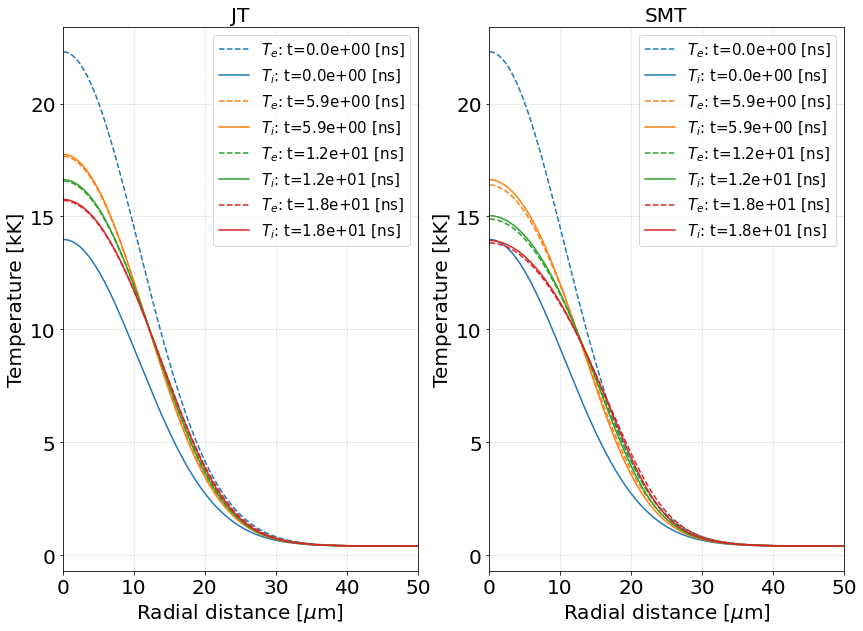

In [36]:
fig, ax = plt.subplots(1,2, figsize=(14,10),facecolor='w')

plot_temp_profiles(ttm_jt, grid, ax = ax[0], title='JT')
plot_temp_profiles(ttm_smt, grid, ax = ax[1], title='SMT')


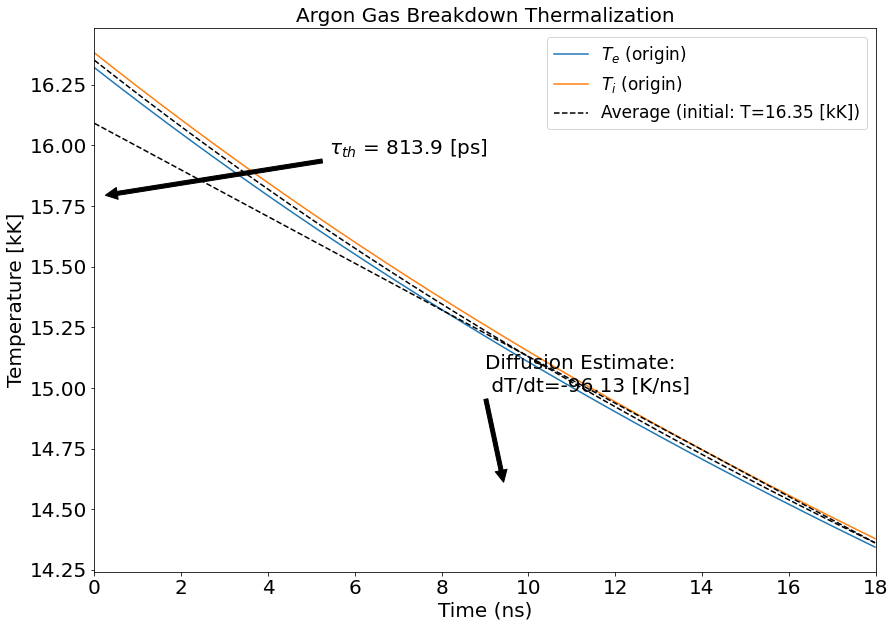

In [14]:
ttm  = ttm_jt
fig, ax = plt.subplots(figsize=(14,10),facecolor='w')

ti_1, ti_2 = -20000, -1
ti_1, ti_2 = -100, -1
T_av_1 = (ttm.Ti_list[ti_1][0] + ttm.Te_list[ti_1][0] )/2
T_av_2 = (ttm.Ti_list[ti_2][0] + ttm.Te_list[ti_2][0] )/2
dT_dt  = (T_av_2 - T_av_1)/(ttm.t_list[ti_2] - ttm.t_list[ti_1])
T_eq_line  = np.array(T_av_1 + dT_dt*(ttm.t_list-ttm.t_list[ti_1]))

T_av = 0.5*(np.array(ttm.Te_list) + np.array(ttm.Ti_list))


ax.plot(np.array(ttm.t_list)*1e9, np.array(ttm.Te_list).T[0]*1e-3,label=r"$T_e$ (origin)")
ax.plot(np.array(ttm.t_list)*1e9, np.array(ttm.Ti_list).T[0]*1e-3,label=r"$T_i$ (origin)")
ax.plot(np.array(ttm.t_list)*1e9, T_eq_line*1e-3,'--k')#,label='Diffusion Estimate: dT/dt={0:.2f} [K/ns]'.format(dT_dt*1e-9))
ax.plot(np.array(ttm.t_list)*1e9, T_av[:,0]*1e-3,'--k',label='Average (initial: T={0:.2f} [kK])'.format(T_av[0,0]*1e-3))

ax.annotate(r'$\tau_{th}$' + ' = {0:.1f} [ps]'.format(ttm.experiment.τei_Equilibration*1e12), xy=(0.1, 0.6), xycoords='figure fraction',
            xytext=(0.3, .8), textcoords='axes fraction',
            va='top', ha='left',fontsize=20,
            arrowprops=dict(facecolor='black', shrink=0.02))

ax.annotate('Diffusion Estimate:\n dT/dt={0:.2f} [K/ns]'.format(dT_dt*1e-9), xy=(0.5, 0.2), xycoords='figure fraction',
            xytext=(0.5, .4), textcoords='axes fraction',
            va='top', ha='left',fontsize=20,
            arrowprops=dict(facecolor='black', shrink=0.02))


# Plot settings
ax.set_xlabel(r"Time (ns)", fontsize=20)
ax.set_ylabel("Temperature [kK]",fontsize=20)
ax.tick_params(labelsize=20)
ax.set_xlim(0,ttm.tmax*1e9)

ax.set_title('Argon Gas Breakdown Thermalization',fontsize=20)
ax.legend(fontsize=17)
plt.show()

### Bulk Temperature Measurement

In [37]:
width_index = np.argmin(np.abs(grid.r - Xenon_jt.laser_width))

Te_bulks = np.array([  grid.integrate_f(Te[:-1]*ttm.n_e[:-1], endpoint=width_index)/grid.integrate_f(ttm.n_e[:-1], endpoint=width_index) for Te in ttm.Te_list])
Ti_bulks = np.array([  grid.integrate_f(Ti[:-1]*ttm.n_i[:-1], endpoint=width_index)/grid.integrate_f(ttm.n_i[:-1], endpoint=width_index) for Ti in ttm.Ti_list])
T_av = 0.5*(Te_bulks + Ti_bulks)


ValueError: operands could not be broadcast together with shapes (499,) (100,) 

In [18]:
Te_bulks, Ti_bulks, T_av

(array([8165.00507022, 8164.26246297, 8163.5203219 , 8162.77863109,
        8162.03737567, 8161.29654172, 8160.55611621, 8159.81608694,
        8159.07644246, 8158.33717206, 8157.5982657 , 8156.85971395,
        8156.12150797, 8155.38363946, 8154.64610064, 8153.90888418,
        8153.1719832 , 8152.43539125, 8151.69910223, 8150.96311043,
        8150.22741045, 8149.49199723, 8148.75686599, 8148.02201222,
        8147.28743167, 8146.55312033, 8145.81907441, 8145.08529035,
        8144.35176475, 8143.61849442, 8142.88547635, 8142.15270766,
        8141.42018564, 8140.68790773, 8139.95587148, 8139.22407458,
        8138.49251483, 8137.76119015, 8137.03009854, 8136.29923812,
        8135.56860708, 8134.83820371, 8134.10802637, 8133.3780735 ,
        8132.64834361, 8131.91883527, 8131.1895471 , 8130.46047782,
        8129.73162615, 8129.00299091, 8128.27457092, 8127.5463651 ,
        8126.81837237, 8126.09059169, 8125.36302209, 8124.63566262,
        8123.90851234, 8123.18157037, 8122.45483

In [19]:
ttm.Te_list[0][width_index]

1183.835834238276

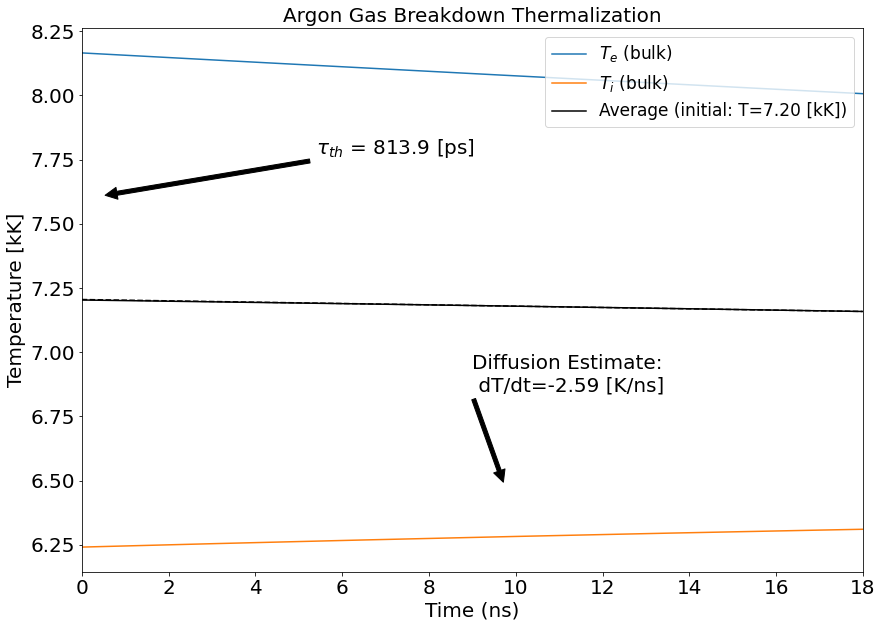

In [38]:
fig, ax = plt.subplots(figsize=(14,10),facecolor='w')


# ti_1, ti_2 = -20000, -1
ti_1, ti_2 = -100, -1

T_av_1 = T_av[ti_1]
T_av_2 = T_av[ti_2]

dT_dt  = (T_av_2 - T_av_1)/(ttm.t_list[ti_2] - ttm.t_list[ti_1])

T_eq_line  = np.array(T_av_1 + dT_dt*(ttm.t_list-ttm.t_list[ti_1]))


ax.plot(np.array(ttm.t_list)*1e9, Te_bulks*1e-3,label=r"$T_e$ (bulk)")
ax.plot(np.array(ttm.t_list)*1e9, Ti_bulks*1e-3,label=r"$T_i$ (bulk)")
ax.plot(np.array(ttm.t_list)*1e9, T_eq_line*1e-3,'--k')#,label='Diffusion Estimate: dT/dt={0:.2f} [K/ns]'.format(dT_dt*1e-9))
ax.plot(np.array(ttm.t_list)*1e9, T_av*1e-3,'-k',label='Average (initial: T={0:.2f} [kK])'.format(T_av[0]*1e-3))

ax.annotate(r'$\tau_{th}$' + ' = {0:.1f} [ps]'.format(ttm.experiment.τei_Equilibration*1e12), xy=(0.1, 0.6), xycoords='figure fraction',
            xytext=(0.3, .8), textcoords='axes fraction',
            va='top', ha='left',fontsize=20,
            arrowprops=dict(facecolor='black', shrink=0.02))

ax.annotate('Diffusion Estimate:\n dT/dt={0:.2f} [K/ns]'.format(dT_dt*1e-9), xy=(0.5, 0.2), xycoords='figure fraction',
            xytext=(0.5, .4), textcoords='axes fraction',
            va='top', ha='left',fontsize=20,
            arrowprops=dict(facecolor='black', shrink=0.02))


# Plot settings
ax.set_xlabel(r"Time (ns)", fontsize=20)
ax.set_ylabel("Temperature [kK]",fontsize=20)
ax.tick_params(labelsize=20)
ax.set_xlim(0,ttm.tmax*1e9)

ax.set_title('Argon Gas Breakdown Thermalization',fontsize=20)
ax.legend(fontsize=17)
plt.show()